In [1]:
import pickle
import pandas as pd

train_data = pickle.load(open("./data/train.pkl", "rb"))
valid_data = pickle.load(open("./data/valid.pkl", "rb"))
test_data = pickle.load(open("./data/test.pkl", "rb"))

train_df = pd.concat([pd.DataFrame(train_data), pd.DataFrame(valid_data)], ignore_index=True)

X_train = train_df.drop(columns=["d_class"])
y_train = train_df["d_class"]

# Data analysis

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_individual_sensors(df):
    """
    Plots each sensor's data in a separate subplot with lines for each d_class, 
    with all classes on top of each other using a standardized time index.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the columns ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'd_class'].
    """
    # Define sensor columns
    sensor_columns = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    
    # Reset the index for each class to make them align on the x-axis
    df = df.copy()  # To avoid modifying the original DataFrame
    df['time_index'] = df.groupby('d_class').cumcount()
    
    # Set up the subplot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, sensor in enumerate(sensor_columns):
        # Create a line plot for each sensor with the standardized time index
        sns.lineplot(data=df, x='time_index', y=sensor, hue='d_class', ax=axes[i])
        
        # Set title and labels
        axes[i].set_title(f'{sensor}')
        axes[i].set_ylabel('Sensor Value')
    
    # Adjust layout and display legend outside of plots
    plt.tight_layout()
    plt.legend(title='Class', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()

# Example usage
# Assuming you have a DataFrame `data` with the specified columns
# plot_individual_sensors(data)


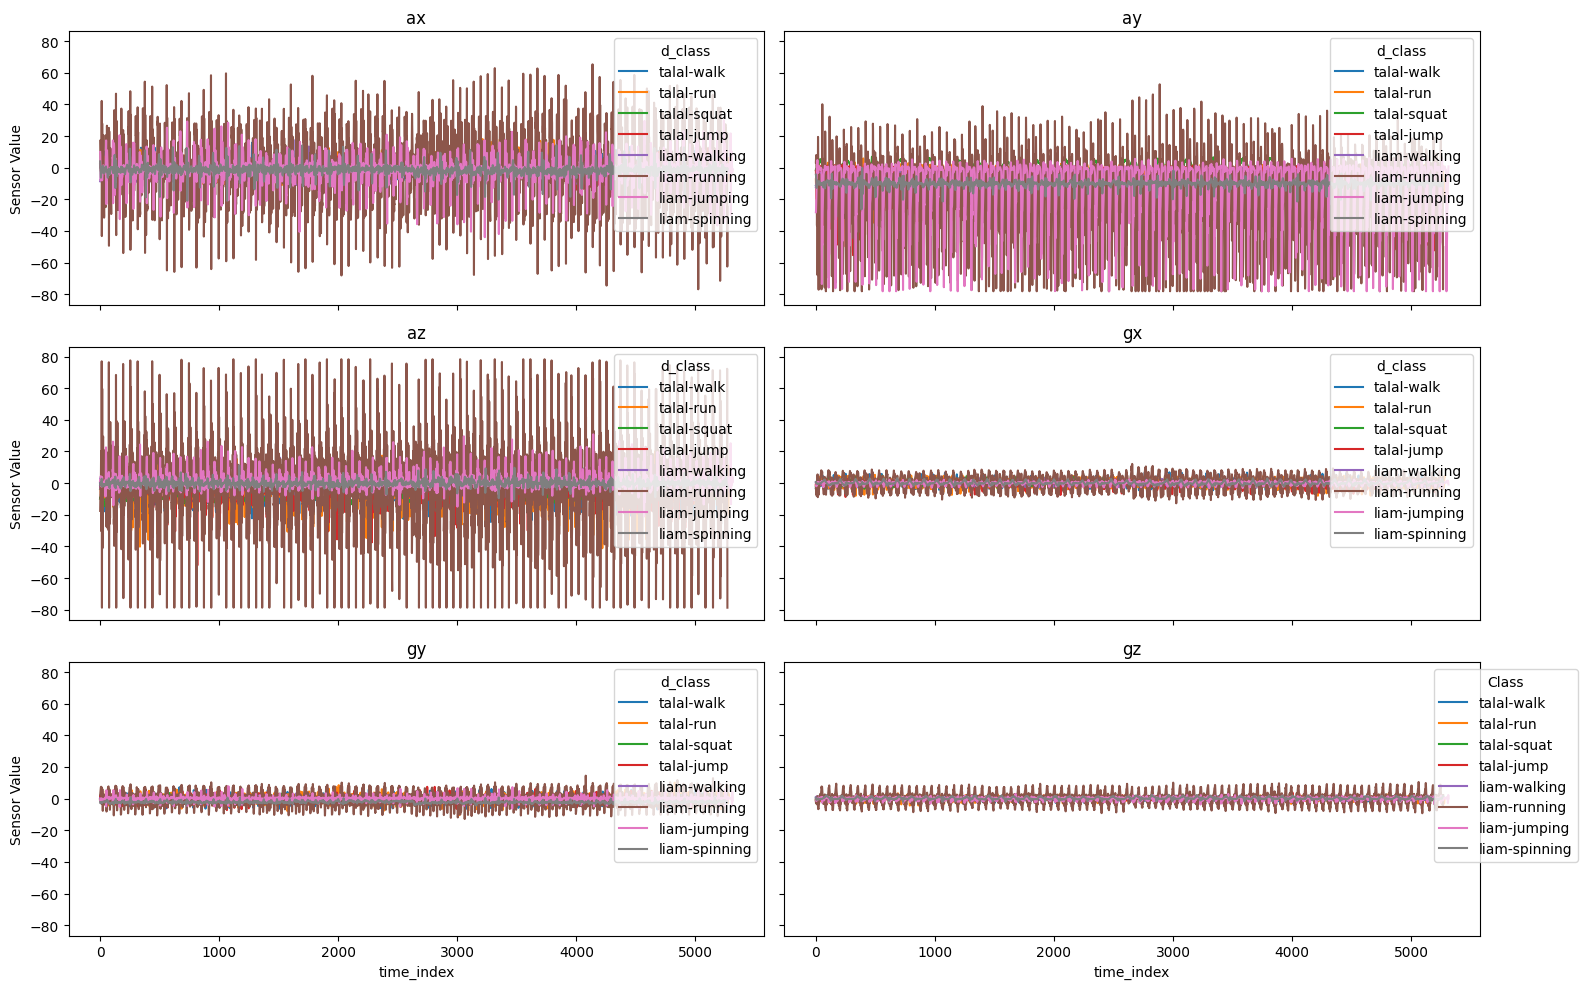

In [10]:
plot_individual_sensors(train_df)

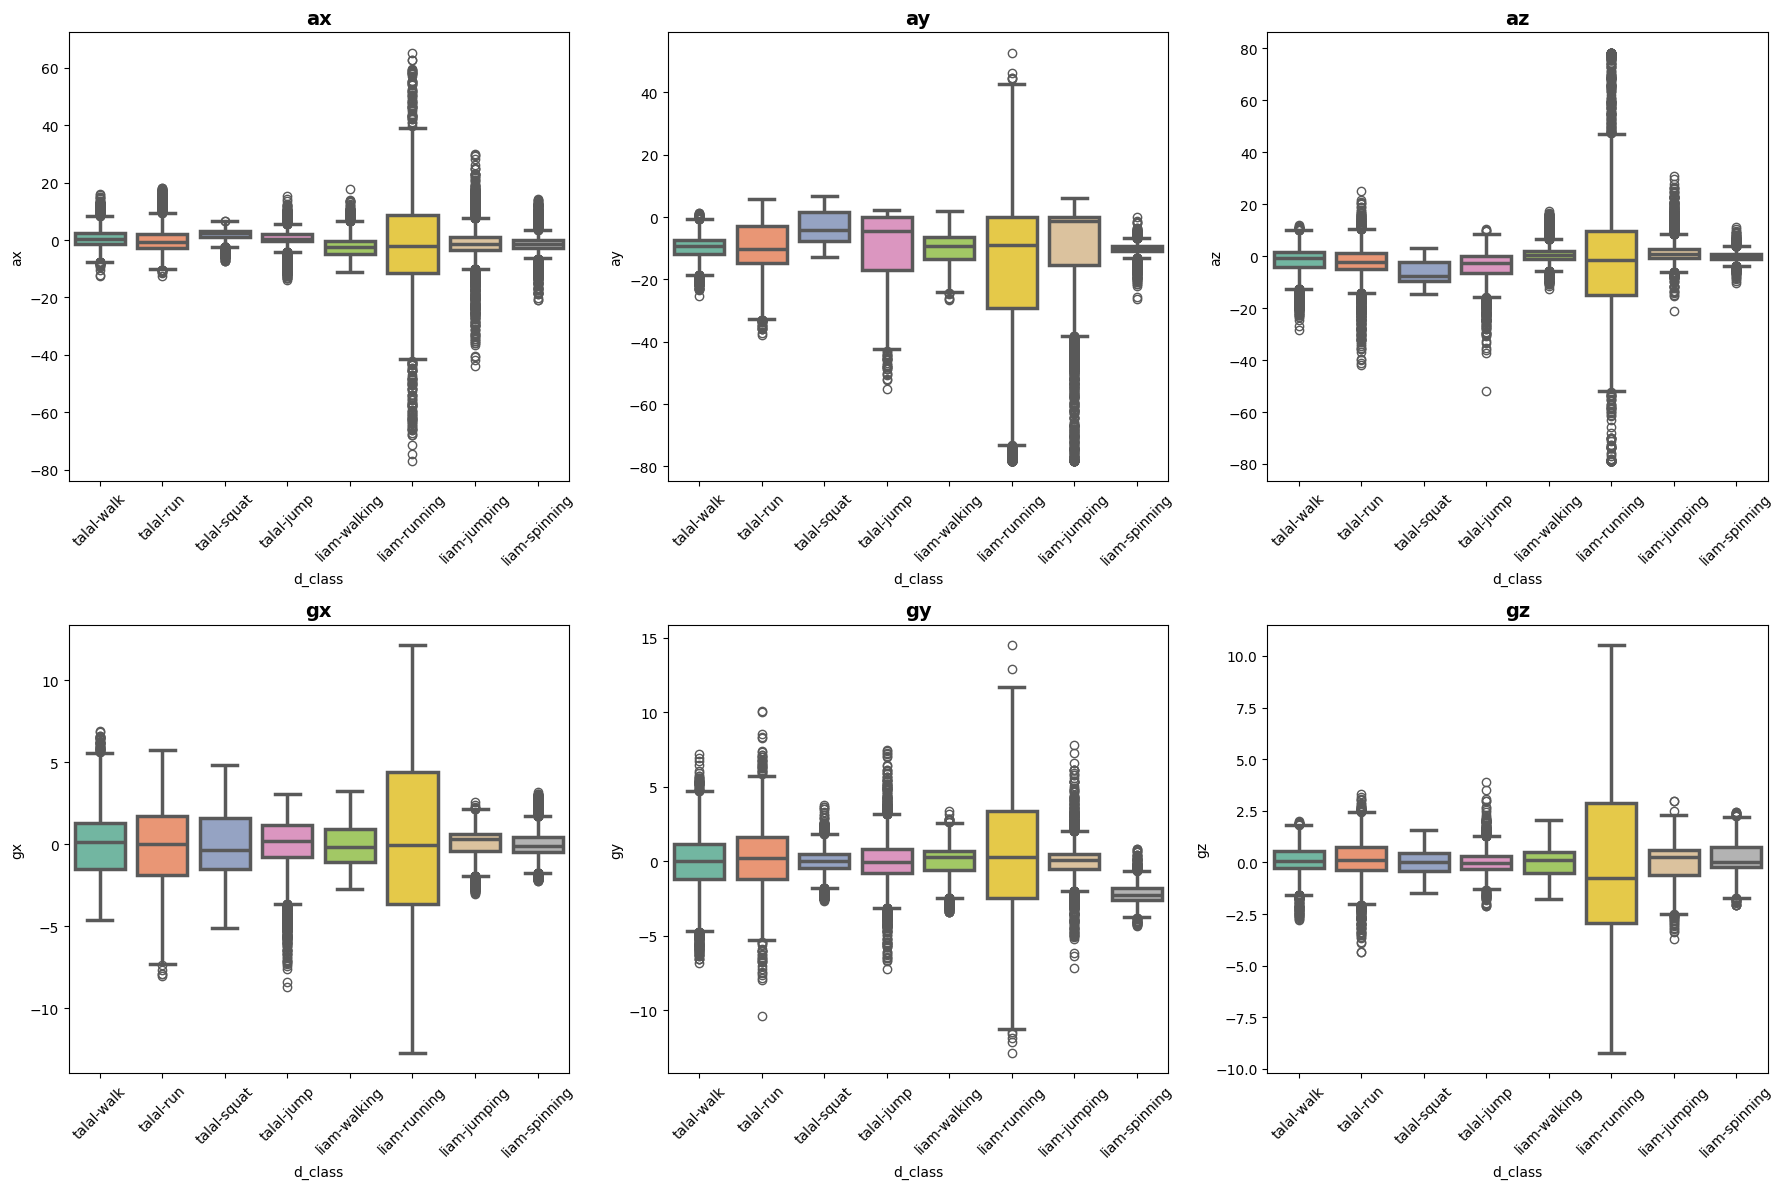

In [4]:
plotting_data = train_df

# Define the columns to plot (excluding 'd_class')
columns = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

# Set up the matplotlib figure
plt.figure(figsize=(18, 12))

# Loop through each column and create a box plot with enhancements
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)  # Create a 2x3 grid of subplots
    
    # Create a box plot with additional enhancements
    sns.boxplot(x='d_class', y=column, hue='d_class', data=plotting_data, linewidth=2.5, palette='Set2', legend=False)
    
    # Overlay a strip plot for additional data points visualization
    # sns.stripplot(x='d_class', y=column, data=plotting_data, jitter=True, size=4, color=".3", alpha=0.2)

    # Customize title and labels
    plt.xticks(rotation=45)
    plt.title(f'{column}', fontsize=14, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the final plot
plt.show()

# Model

In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [5]:
import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import GRU, Dense
from keras.api.optimizers import Adam
import numpy as np

2024-10-28 20:30:35.533062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730147435.596814      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730147435.618004      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 20:30:35.771283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def prepare_data_windows(data, target, window_size):
    X_windows = []
    y_windows = []
    for i in range(len(data) - window_size):
        X_windows.append(data[i:i + window_size])
        y_windows.append(target[i + window_size])
    return np.array(X_windows), np.array(y_windows)

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from kerastuner import HyperModel, Hyperband
import os
import datetime

# Define the HyperModel class
class GRUHyperModel(HyperModel):
    def build(self, hp):
        num_neurons = hp.Choice('num_neurons', [32, 64, 128])
        num_layers = hp.Choice('num_layers', [1, 2])
        window_size = hp.Choice('window_size', [50, 100, 150])
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

        model = Sequential()
        for _ in range(0, num_layers - 1):
            model.add(GRU(num_neurons, activation='tanh', return_sequences=True, input_shape=(window_size, 6)))
            model.add(Dropout(dropout_rate)) 

        model.add(GRU(num_neurons, activation='tanh'))
        model.add(Dropout(dropout_rate))  
        model.add(Dense(10, activation='softmax'))  

        model.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
        return model

# Create the HyperModel instance
hypermodel = GRUHyperModel()

# Initialize Keras Tuner with Hyperband
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,  # Maximum number of epochs to train each model
    hyperband_iterations=2,  # Number of Hyperband iterations
    directory='tuner_dir',
    project_name='gru_tuning',
    overwrite=True
)

# Create a directory for TensorBoard logs
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the ModelCheckpoint callback
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model-{epoch:02d}-{val_accuracy:.2f}.keras"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Run the hyperparameter search
X_windows, y_windows = prepare_data_windows(X_train, y_train, 150)

tuner.search(X_windows, y_windows, epochs=10, validation_split=0.2, 
             callbacks=[tensorboard_callback, checkpoint_callback], verbose=2)

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Num Neurons: {best_hyperparameters.get('num_neurons')}")
print(f"Num Layers: {best_hyperparameters.get('num_layers')}")
print(f"Window Size: {best_hyperparameters.get('window_size')}")
print(f"Dropout Rate: {best_hyperparameters.get('dropout_rate')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")


Trial 2 Complete [00h 00m 00s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |64                |num_neurons
2                 |2                 |num_layers
100               |100               |window_size
0.5               |0.3               |dropout_rate
0.000166          |0.00011918        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ke

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/optree/ops.py", line 747, in tree_map
    return treespec.unflatten(map(func, *flat_args))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Invalid dtype: str416
